In [1]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3
    

In [2]:
import data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm
torch.cuda.empty_cache()

In [3]:
mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

In [4]:
# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
train_data1=torch.tensor(hypData.spectraPrep[:trainSamples, :].astype(np.float32)).unsqueeze(1)
dataTrain = data.Iterator( dataSamples=train_data1,
                        targets=train_data1, batchSize=1000 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [5]:
trainSamples = 200000
valSamples = 100


In [6]:
# shuffle training data
dataTrain.shuffle()

In [7]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [8]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [9]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Conv1d(1, 50,kernel_size = 3, stride = 1)  # 64-16-2-16-64
    self.enn2 = T.nn.Conv1d(50, 30,kernel_size = 3, stride = 1)
    self.enn3 = T.nn.Conv1d(30,10,kernel_size = 3, stride = 1)
    self.dnn3 = T.nn.ConvTranspose1d(10, 30,3)  # 64-16-2-16-64
    self.dnn2 = T.nn.ConvTranspose1d(30, 50,3)
    self.dnn1 = T.nn.ConvTranspose1d(50,1,3)
    self.flatten=T.nn.Flatten()
    self.dense1 = T.nn.Linear(10*97, 10)
    self.dense2 = T.nn.Linear(10,10*97)
    self.unflatten=T.nn.Unflatten(1,[10,97])
  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    z= self.flatten(z)
    z= T.relu(self.dense1(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dense2(x))
    z= self.unflatten(z)
    z= T.relu(self.dnn3(z))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    z=self.encoder(x)
    z= self.decoder(z)
    
    return z
net=Net().to(device)
inpu=torch.rand(50,1,103).to(device)
print(inpu.shape)
outp=net(inpu)
outp.shape


torch.Size([50, 1, 103])


torch.Size([50, 1, 103])

In [10]:
train_data = torch.tensor(dataTrain.dataSamples)
train_data

C:\Users\naras\AppData\Local\Temp\ipykernel_18308\3915235939.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(dataTrain.dataSamples)


tensor([[[5.1873e-01, 5.7925e-01, 5.6917e-01,  ..., 4.4957e-01,
          4.7118e-01, 4.5677e-01]],

        [[5.2056e-07, 2.6029e-02, 1.8220e-01,  ..., 3.8938e-01,
          3.8313e-01, 3.9511e-01]],

        [[2.9585e-01, 1.4408e-01, 3.9748e-02,  ..., 8.3604e-01,
          8.1888e-01, 8.3198e-01]],

        ...,

        [[9.2134e-02, 4.4329e-02, 4.3459e-07,  ..., 3.6897e-01,
          3.9765e-01, 3.9157e-01]],

        [[4.1634e-01, 2.4511e-01, 8.8063e-02,  ..., 7.9648e-01,
          8.1213e-01, 8.1262e-01]],

        [[9.2601e-01, 8.0269e-01, 6.1435e-01,  ..., 8.1839e-01,
          7.6906e-01, 7.1525e-01]]])

In [11]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 2*8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 1000
ep_log_interval = 5
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = T.nn.MSELoss()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  time.sleep(0.5)
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0
  for (batch_idx, batch) in loop:
    X = batch.to(device)  # no targets needed

    optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt, X)  # note: X not Y
    loss_obj1=loss_func1(oupt,X)
    epoch_loss += loss_obj.item()  # accumulate
    mseloss+=loss_obj1.item()
    loss_obj.backward()
    optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss),mseloss=str(mseloss))

    

  #if epoch % ep_log_interval == 0:
    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()






Begin UCI digits auto-reduce-viz demo job 

Creating 64-16-2-16-63 autoencoder 

bat_size = 16368 
loss = MSELoss()
optimizer = Adam
max_epochs = 1000 
lrn_rate = 0.000 

Starting training


Epoch [135/1000]: 100%|███████████| 13/13 [00:01<00:00, 10.18it/s, loss=0.0196873783133924, mseloss=0.0196873783133924]


Epoch [271/1000]: 100%|███████| 13/13 [00:01<00:00, 10.20it/s, loss=0.010511809552554041, mseloss=0.010511809552554041]


Epoch [407/1000]: 100%|███████| 13/13 [00:01<00:00,  9.97it/s, loss=0.008376254583708942, mseloss=0.008376254583708942]


Epoch [543/1000]: 100%|███████| 13/13 [00:01<00:00, 10.12it/s, loss=0.007607742270920426, mseloss=0.007607742270920426]


Epoch [679/1000]: 100%|███████| 13/13 [00:01<00:00, 10.24it/s, loss=0.006911393720656633, mseloss=0.006911393720656633]


Epoch [815/1000]: 100%|███████| 13/13 [00:01<00:00, 10.10it/s, loss=0.005882450146600604, mseloss=0.005882450146600604]


Epoch [951/1000]: 100%|███████| 13/13 [00:01<00:00, 10.18it/s, loss=0.005360956332879141, mseloss=0.005360956332879141]


Epoch [999/1000]: 100%|███████| 13/13 [00:01<00:00, 10.26it/s, loss=0.005315386515576392, mseloss=0.005315386515576392]


Done 

Creating graph from encoded data 


In [18]:
loss_obj

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)

In [19]:

#torch.save(net, 'model_conv_mse_run.pth')

In [20]:
torch.save(net.state_dict(), 'net_model_conv_mse_run.pth')

In [11]:
net.load_state_dict(torch.load('net_model_conv_mse_run.pth'))

<All keys matched successfully>

In [12]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
#rex = trex.shape[0],1
trex = trex.reshape(207400,1,103)
trex.shape

torch.Size([207400, 1, 103])

In [13]:
dataZ=net.encoder(trex.to("cuda"))
dataZ.shape

RuntimeError: CUDA out of memory. Tried to allocate 3.90 GiB (GPU 0; 8.00 GiB total capacity; 3.99 GiB already allocated; 1.72 GiB free; 3.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
mini_batch=10000
sendin=torch.empty(0,10).to("cuda")
sendout=torch.empty(0,1,103).to("cuda")
with torch.no_grad():
    net.eval()
    
    for i in range(0,trex.shape[0],mini_batch):
        
        boo=trex[i:i+mini_batch]
        dataZ=net.encoder(boo.to("cuda"))
        dataY = net.decoder(dataZ)
        sendin=torch.cat((sendin,dataZ))
        sendout=torch.cat((sendout,dataY))
        
print(sendout.shape,sendin.shape)

torch.Size([207400, 1, 103]) torch.Size([207400, 10])


In [15]:
trex.shape[0]

207400

In [16]:
dataZ.shape

torch.Size([7400, 10])

In [17]:
boo.shape

torch.Size([7400, 1, 103])

In [18]:
kaka=torch.empty(128,10,97).to("cuda")
with torch.no_grad():
    net.eval()
    
    for i in range(0,trex.shape[0],128):
        boo=trex[i:i+128]
        dataZ=net.encoder(boo.to("cuda"))
        kaka=torch.cat([kaka,dataZ])
kaka

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [19]:
dataY = net.decoder(dataZ)
dataY.shape

torch.Size([128, 1, 103])

In [20]:
sendout.reshape(sendout.shape[0],sendout.shape[2]).shape

torch.Size([207400, 103])

In [21]:
hypData.numRows

610

In [22]:
sendout.squeeze(1).shape

torch.Size([207400, 103])

In [23]:
imgZ = np.reshape(sendin.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [24]:
imgY = np.reshape(sendout.squeeze(1).to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [25]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))

In [26]:
hypData.spectraPrep.shape

(207400, 103)

In [27]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

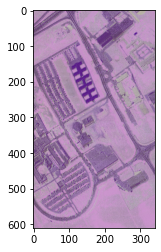

In [28]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

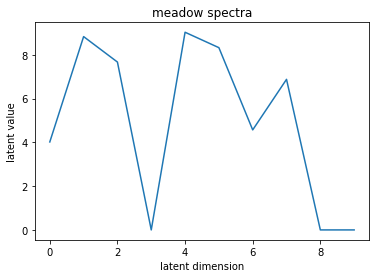

In [29]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

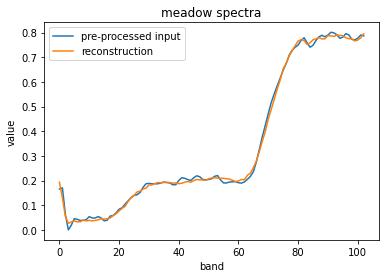

In [30]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()

In [31]:
 #--------- visualisation ----------------------------------------

 # download dataset ground truth pixel labels (if already downloaded, comment this out).
 urlretrieve( 'http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat',
                         os.path.join(os.getcwd(), 'PaviaU_gt.mat') )

('C:\\Users\\naras\\Model_train\\Conv1-Autoenc\\PaviaU_gt.mat',
 <http.client.HTTPMessage at 0x10988849c10>)

In [32]:
# read labels into numpy array
mat_gt = scipy.io.loadmat( 'PaviaU_gt.mat' )
img_gt = mat_gt['paviaU_gt']
gt = np.reshape( img_gt , ( -1 ) )
gt

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [33]:
dataZ.detach()

tensor([[4.0788, 9.2815, 7.2902,  ..., 6.3015, 0.0000, 0.0000],
        [3.9101, 9.2304, 7.2879,  ..., 6.5314, 0.0000, 0.0000],
        [4.2035, 9.3125, 7.3509,  ..., 6.5874, 0.0000, 0.0000],
        ...,
        [4.0961, 8.8183, 7.6326,  ..., 6.4285, 0.0000, 0.0000],
        [4.1030, 8.7831, 7.4027,  ..., 6.4142, 0.0000, 0.0000],
        [4.0068, 8.9730, 7.6207,  ..., 6.5469, 0.0000, 0.0000]],
       device='cuda:0')

In [34]:
imz=imgZ
imz = imz[:,:,0]
imz=imz.reshape(-1)
imz.shape

(207400,)

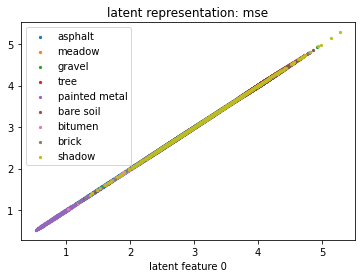

In [35]:
dataZ_collection = [imz]

for j,dataZ in enumerate(dataZ_collection):
    # save a scatter plot image of 2 of 3 latent dimensions
    std_dZ = -np.std(imz,axis=0)
    idx = np.argsort(std_dZ)
    fig, ax = plt.subplots()
    for i,gt_class in enumerate(['asphalt', 'meadow', 'gravel','tree','painted metal','bare soil','bitumen','brick','shadow']):
     ax.scatter(imz[gt == i+1], imz[gt == i+1], c='C%i'%i,s=5,label=gt_class)
    ax.legend()
    plt.title('latent representation: mse')
    plt.xlabel('latent feature %i' % (idx[0]))
#    plt.ylabel('latent feature %i' % (idx[1]))

In [36]:
idx.shape

(1,)

In [37]:
from math import log10, sqrt
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def main():
     original = imgX[576, 210, :]
     compressed = imgY[576, 210, :]
     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    main()

PSNR value is 86.49544922475486 dB


In [38]:
psnr=[]
import statistics
for i in range(hypData.numBands):
    original = imgX[:, :, i]
    compressed = imgY[:, :, i]
    value = PSNR(original, compressed)
    psnr.append(value)
    

print(f" Mean PSNR value is {statistics.mean(psnr)} dB")

 Mean PSNR value is 83.11766216225134 dB


In [39]:
from skimage.metrics import structural_similarity
##skimage.metrics.
import argparse
import imutils
import cv2



# 3. Load the two input images
imageA = imgX[:, :, 1]
imageB = imgY[:, :, 1]

# 4. Convert the images to grayscale
#grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
#grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)


# 5. Compute the Structural Similarity Index (SSIM) between the two
#    images, ensuring that the difference image is returned
(score, diff) = structural_similarity(imageA, imageB, full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))



SSIM: 0.9005241027476326


D:\Anaconda\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [57]:
eps = 1e-10

#Cross-correlation matrix
def cross_correlation(H_fuse, H_ref):
    N_spectral = H_fuse.shape[2]

    # Rehsaping fused and reference data
    H_fuse_reshaped = H_fuse.view(N_spectral, -1)
    H_ref_reshaped = H_ref.view(N_spectral, -1)

    # Calculating mean value
    mean_fuse = torch.mean(H_fuse_reshaped, 1).unsqueeze(1)
    mean_ref = torch.mean(H_ref_reshaped, 1).unsqueeze(1)

    CC = torch.sum((H_fuse_reshaped- mean_fuse)*(H_ref_reshaped-mean_ref), 1)/torch.sqrt(torch.sum((H_fuse_reshaped- mean_fuse)**2, 1)*torch.sum((H_ref_reshaped-mean_ref)**2, 1))

    CC = torch.mean(CC)
    return CC

# Spectral-Angle-Mapper (SAM)
def SAM(H_fuse, H_ref):
    #Compute number of spectral bands
    N_spectral = H_fuse.shape[1]

    # Rehsaping fused and reference data
    H_fuse_reshaped = H_fuse.view(N_spectral, -1)
    H_ref_reshaped  = H_ref.view(N_spectral, -1)
    N_pixels = H_fuse_reshaped.shape[1]
    
    # Calculating inner product
    inner_prod  = torch.nansum(H_fuse_reshaped*H_ref_reshaped, 0)
    fuse_norm   = torch.nansum(H_fuse_reshaped**2, dim=0).sqrt()
    ref_norm    = torch.nansum(H_ref_reshaped**2, dim=0).sqrt()

    # Calculating SAM
    SAM = torch.rad2deg(torch.nansum( torch.acos(inner_prod/(fuse_norm*ref_norm)) )/N_pixels)
    return SAM

In [67]:
cross_correlation(imgX,imgY)

ValueError: Type must be a sub-type of ndarray type

In [65]:
imgx =torch.tensor(imgX).shape

In [66]:
 imgX.view(103,-1)

ValueError: Type must be a sub-type of ndarray type